## Libs import and config

In [185]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import os
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 500)
pd.set_option('display.max_rows', 500)

In [1]:
filepath = '/Users/leoguillaume/Documents/openclassrooms-projects/openclassrooms-project-2/data/Projet+Python_Dataset_Edstats_csv/'

## Data import

In [3]:
csv_list = os.listdir(filepath)

In [4]:
for csv in csv_list:
    locals()[csv[:-4]] = pd.read_csv(os.path.join(filepath,csv))

In [5]:
for csv in csv_list:
    print(csv+'\n'+40*'-')
    locals()[csv[:-4]].info()
    print('\n')

EdStatsCountry.csv
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                  

## Tables contents

EdStatsSeries : informations about indicators (descriptions) >> for feature selection

EdStatsCountry : country statistics (use incomes group)

EdStatsCountrySeries : sources of StatSeries >> useless

EdStatsData : country education statistics >> main data

EdStatsFootNote : year of country indicator of EdStatsData are present >> for filtered EdStatsData with % data score

## Datapoints (~missing values)
### By EdStatsFootNote

In [11]:
edstatsfootnote_datapoints_counts = EdStatsFootNote.groupby('CountryCode').count()

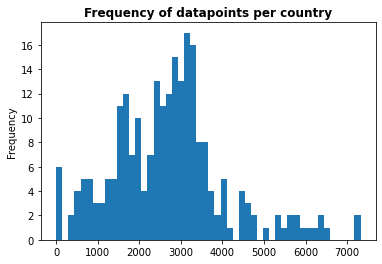

In [22]:
plt.figure()
plt.title('Frequency of datapoints per country', weight = 'bold')
edstatsfootnote_datapoints_counts.SeriesCode.plot(kind = 'hist', bins = 50)
plt.show()

### By EdStatsData

In [66]:
for column in EdStatsData:
    try:
        if int(column) > 2020:
            EdStatsData.drop(columns = column, inplace = True)
    except:
        pass

In [71]:
EdStatsData.drop(columns = 'Unnamed: 69', inplace = True)

In [186]:
country_datapoints = EdStatsData.groupby('Country Name').count().drop(columns = ['Country Code', 'Indicator Name', 'Indicator Code']).sum(axis = 1)

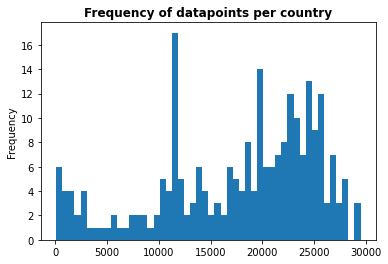

In [187]:
plt.figure()
plt.title('Frequency of datapoints per country', weight = 'bold')
country_datapoints.plot(kind = 'hist', bins = 50)
plt.show()

### World map of datapoints

In [244]:
geolocator = Nominatim(user_agent="openclassroom_project_2")

In [202]:
geo_dict = dict()
for country, datapoints in country_datapoints.iteritems():
    try:
        location = geolocator.geocode(country)
        latitude = location.latitude
        longitude = location.longitude
        geo_dict[country] = dict()
        geo_dict[country]['latitude'] = latitude
        geo_dict[country]['longitude'] = longitude
        geo_dict[country]['datapoints'] = datapoint
    except Exception as e:
        print(f'Error {e} for {country}')

Error 'NoneType' object has no attribute 'latitude' for Congo, Dem. Rep.
Error 'NoneType' object has no attribute 'latitude' for Congo, Rep.
Error 'NoneType' object has no attribute 'latitude' for East Asia & Pacific (excluding high income)
Error 'NoneType' object has no attribute 'latitude' for Egypt, Arab Rep.
Error 'NoneType' object has no attribute 'latitude' for Europe & Central Asia (excluding high income)
Error 'NoneType' object has no attribute 'latitude' for Heavily indebted poor countries (HIPC)
Error 'NoneType' object has no attribute 'latitude' for Hong Kong SAR, China
Error 'NoneType' object has no attribute 'latitude' for Iran, Islamic Rep.
Error 'NoneType' object has no attribute 'latitude' for Korea, Dem. People’s Rep.
Error 'NoneType' object has no attribute 'latitude' for Korea, Rep.
Error 'NoneType' object has no attribute 'latitude' for Latin America & Caribbean (excluding high income)
Error 'NoneType' object has no attribute 'latitude' for Least developed countries

In [241]:
m = folium.Map(location=[12,1], zoom_start=2)
for country in geo_dict.keys():
    folium.Circle(location=[geo_dict[country]['latitude'], geo_dict[country]['longitude']],
                  popup=country,
                  radius= geo_dict[country]['datapoints'] * 10,
                  color='crimson',
                  fill=True,
                  fill_color='crimson').add_to(m)

In [242]:
m

## Duplicates values

In [111]:
f"% of duplicates values in EdStatsData: {(len(EdStatsData) - len(EdStatsData.drop(columns = ['Indicator Name', 'Indicator Code']).drop_duplicates())) / len(EdStatsData):.2%}"

'% of duplicates values in EdStatsData: 61.87%'

> Many indicators measure the same things!

## Shape tables descriptions

In [155]:
print('Row\n' + 30*'-')
for csv in csv_list:
    print(f"{csv}: {str(locals()[csv[:-4]].shape[0])}")
    
print('\nFeaures\n' + 30*'-')
for csv in csv_list:
    print(f"{csv}: {str(locals()[csv[:-4]].shape[1])}")  

Row
------------------------------
EdStatsCountry.csv: 241
EdStatsCountry-Series.csv: 613
EdStatsData.csv: 886930
EdStatsFootNote.csv: 643638
EdStatsSeries.csv: 3665

Feaures
------------------------------
EdStatsCountry.csv: 32
EdStatsCountry-Series.csv: 4
EdStatsData.csv: 53
EdStatsFootNote.csv: 5
EdStatsSeries.csv: 21


## Get languages

In [252]:
import pycountry

In [ ]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

In [262]:
codes = {country:countries.get(country, 'Unknown code') for country in EdStatsData['Country Name'].unique()}

In [258]:
import lxml.etree
import urllib.request

def get_territory_languages():
    url = "https://raw.githubusercontent.com/unicode-org/cldr/master/common/supplemental/supplementalData.xml"
    langxml = urllib.request.urlopen(url)
    langtree = lxml.etree.XML(langxml.read())

    territory_languages = {}
    for t in langtree.find('territoryInfo').findall('territory'):
        langs = {}
        for l in t.findall('languagePopulation'):
            langs[l.get('type')] = {
                'percent': float(l.get('populationPercent')),
                'official': bool(l.get('officialStatus'))
            }
        territory_languages[t.get('type')] = langs
    return territory_languages

In [260]:
territory_languages = get_territory_languages()

In [264]:
territory_languages

{'AC': {'en': {'percent': 99.0, 'official': False}},
 'AD': {'ca': {'percent': 51.0, 'official': True},
  'es': {'percent': 43.0, 'official': False},
  'fr': {'percent': 7.5, 'official': False}},
 'AE': {'ar': {'percent': 78.0, 'official': True},
  'en': {'percent': 50.0, 'official': False},
  'ml': {'percent': 7.0, 'official': False},
  'ps': {'percent': 2.9, 'official': False},
  'bal': {'percent': 2.3, 'official': False},
  'fa': {'percent': 1.9, 'official': False}},
 'AF': {'fa': {'percent': 50.0, 'official': True},
  'ps': {'percent': 43.0, 'official': True},
  'haz': {'percent': 5.9, 'official': False},
  'uz_Arab': {'percent': 4.7, 'official': True},
  'tk': {'percent': 1.7, 'official': True},
  'prd': {'percent': 1.2, 'official': False},
  'bgn': {'percent': 0.63, 'official': False},
  'ug': {'percent': 0.0082, 'official': False},
  'kk_Arab': {'percent': 0.0055, 'official': False}},
 'AG': {'en': {'percent': 86.0, 'official': True},
  'pt': {'percent': 1.6, 'official': False}}